#GAN(Generative Adversarial Network):
Generative Adversarial Networks, or GANs for short, are an approach to generative modeling using deep learning methods, such as convolutional neural networks.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

GANs are a clever way of training a generative model by framing the problem as a supervised learning problem with two sub-models,the first one is generator model by which we can train to generate new examples and the second one is discriminator model by which we can classify the examples as real (from the domain) or fake (generated). The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.

GANs are an exciting and rapidly changing field, delivering on the promise of generative models in their ability to generate realistic examples across a range of problem domains, most notably in image-to-image translation tasks such as translating photos of summer to winter or day to night, and in generating photorealistic photos of objects, scenes, and people that even humans cannot tell are fake.

#DATASET
We can usees the opendatasets library to download the dataset from Kaggle. opendatasets uses the Kaggle Official API for downloading datasets from Kaggle. Follow these steps to find your API credentials:

1. Sign in to https://kaggle.com/, then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents:

  {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
3. When you run opendatsets.download, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.
Note that you need to download the kaggle.json file only once. On Google Colab, you can also upload the kaggle.json file using the files tab, and the credentials will be read automatically.



In [107]:
#!pip install -q kaggle
!pip install opendatasets --upgrade --quiet


In [108]:
import opendatasets as od

In [109]:
dataset_url = 'https://www.kaggle.com/ikarus777/best-artworks-of-all-time'

In [110]:
od.download(dataset_url)

Skipping, found downloaded files in "./best-artworks-of-all-time" (use force=True to force download)


#Import the dataset into PyTorch
###This dataset is comprised of 2 folders:
images: This folder contains all image files within folders of artists.
resized: This folder contains all image files within one folder.
As a GAN classifies the data as real or fake, the artist categories are not needed so I will only use the files in the resized folder.
Use the ImageFolder class from torchvision.


In [111]:
data_dir = '/content/best-artworks-of-all-time/resized/'

In [112]:
import os

In [113]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

resized : 8683


In [114]:
from torchvision.datasets import ImageFolder

In [115]:
dataset = ImageFolder(data_dir)

In [116]:
len(dataset)

8683

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

#Let's see some of art pictures present in dataset.

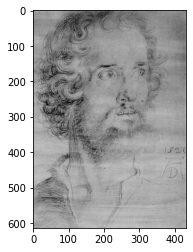

In [118]:
img, label = dataset[0]
plt.imshow(img)

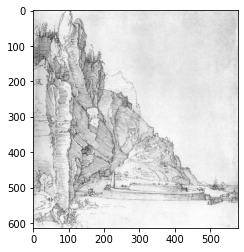

In [119]:
img, label = dataset[500]
plt.imshow(img)

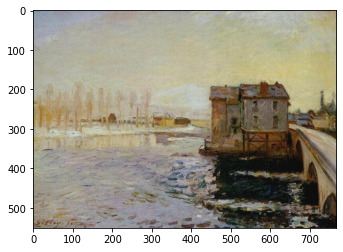

In [120]:
img, label = dataset[741]
plt.imshow(img)

#Making batches of picture:

1.   First I'll resize and center crop all images to ensure that they are all in same shape and size.

2. Then convert them to tensors and normalize them.
3. Then create the data loader.
4. Then look at some samples.



In [121]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader

In [122]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [123]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [124]:
from torchvision.utils import make_grid

In [125]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [126]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


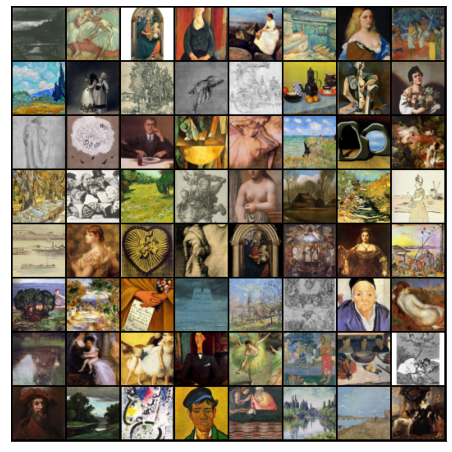

In [127]:
show_batch(train_dl)

#Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class "DeviceDataLoader" to move our model & data to the GPU, if one is available.

In [128]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [129]:
import torch

In [130]:
device = get_default_device()
device

device(type='cuda')

In [131]:
train_dl = DeviceDataLoader(train_dl, device)

#Discriminator Network
The discriminator takes  image as an input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [132]:
import torch.nn as nn

In [133]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [134]:
discriminator = to_device(discriminator, device)

#Generator Network
The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

In [135]:
latent_size = 128

In [136]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

#Let's see how our first generative image look's like .

torch.Size([128, 3, 64, 64])


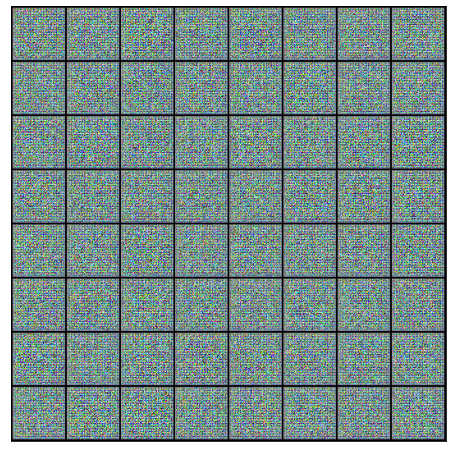

In [137]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

It seems like it's really poor.So for that now we have to train our model.

In [138]:
generator = to_device(generator, device)

#Discriminator Training
Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

###Here are the steps involved in training the discriminator.

1. We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

2. We first pass a batch of real images, and compute the loss, setting the target labels to 1.

3. Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

4. Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

In [139]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#Generator Training
Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

1. We generate a batch of images using the generator, pass it into the discriminator.

2. We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

3. We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [140]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [141]:
from torchvision.utils import save_image

In [142]:
import os
sample_dir0 = '/drive/MyDrive/generated/'
sample_dir='/drive/MyDrive/generated00/'
os.makedirs(sample_dir, exist_ok=True)
try:
    os.mkdir(sample_dir0)
except OSError as error:
    print(error) 


[Errno 17] File exists: '/drive/MyDrive/generated/'


In [143]:
 # from google.colab import drive
 # drive.mount('/drive')

In [144]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir0, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [145]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


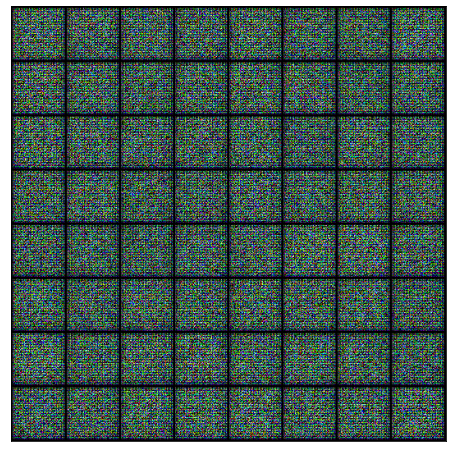

In [146]:
save_samples(0, fixed_latent)


## Full Training Loop

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [147]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [148]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        if epoch%10==0:
         save_samples(epoch+start_idx, fixed_latent, show=True)
         plt.savefig(f"{sample_dir0}/epoch+start_idx.png")

    
    return losses_g, losses_d, real_scores, fake_scores

In [149]:
lr = 0.002
epochs = 50
print(epochs)

50


In [150]:
history = fit(epochs, lr,start_idx=1)

Output hidden; open in https://colab.research.google.com to view.

In [151]:
losses_g, losses_d, real_scores, fake_scores = history

In [152]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

#Now start viewing some of generative pictures....and see the progress as epochs numbers increasing.

In [153]:
from IPython.display import Image

In [154]:
Image('./generated/generated-images-0001.png')

In [155]:
Image('./generated/generated-images-0005.png')

In [156]:
Image('./generated/generated-images-0010.png')

In [157]:
Image('./generated/generated-images-0015.png')

In [158]:
Image('./generated/generated-images-0020.png')

In [159]:
Image('./generated/generated-images-0025.png')

In [160]:
Image('./generated/generated-images-0030.png')

In [161]:
Image('./generated/generated-images-0035.png')

In [162]:
Image('./generated/generated-images-0040.png')

In [163]:
Image('./generated/generated-images-0045.png')

In [164]:
Image('./generated/generated-images-0050.png')

#Results
1. Make a video on generative pictures.
2. Graphs

In [165]:
import cv2
import os

vid_fname = 'art_gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

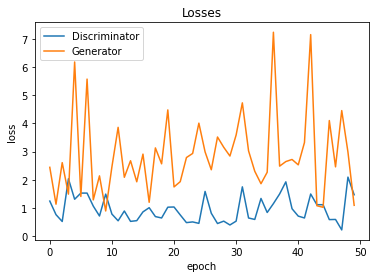

In [166]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

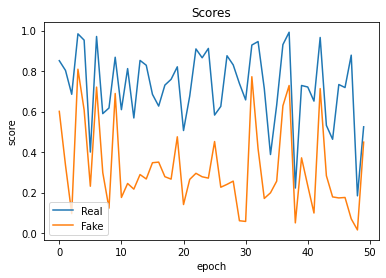

In [167]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

#Conclusion
Here we are seeing that the fake pictures quality is good but fake images prediction values are not very good.So now again we can run it using lower learning rate(lr) and near about 80-100 epoches may be able to increase the fake images prediction value.
 